# Exploring Dandiset 001366: Comparison of Approaches for Surface Vessel Diameter and Pulsatility Quantification

**Note:** This notebook was generated with the assistance of AI. Please be cautious when interpreting the code or results and verify findings independently.

## Overview

This Dandiset contains high-temporal resolution movies of pial vessels in mice, designed to compare different methods for quantifying surface vessel diameter and pulsatility. The data includes grayscale imaging movies that capture vessel dynamics at high frame rates, enabling detailed analysis of vascular pulsation and diameter changes over time.

**Dandiset URL:** https://dandiarchive.org/dandiset/001366/0.250324.1603

The dataset includes recordings from two subjects with different imaging parameters and experimental conditions, providing opportunities for comparative vessel analysis and algorithm benchmarking.

## Required Packages

The following packages are required to run this notebook:
- `dandi`
- `pynwb`
- `h5py`
- `remfile`
- `matplotlib`
- `numpy`

In [1]:
# Import required packages
from dandi.dandiapi import DandiAPIClient
import remfile
import h5py
import pynwb
import matplotlib.pyplot as plt
import numpy as np

## Exploring the Dandiset with DANDI API

In [2]:
# Connect to the Dandiset and get basic metadata
client = DandiAPIClient()
dandiset = client.get_dandiset("001366", "0.250324.1603")
metadata = dandiset.get_raw_metadata()

print(f"Dandiset name: {metadata['name']}")
print(f"Dandiset URL: {metadata['url']}")
print(f"Description: {metadata['description']}")

Dandiset name: Comparison of Approaches for Surface Vessel Diameter and Pulsatility Quantification
Dandiset URL: https://dandiarchive.org/dandiset/001366/0.250324.1603
Description: movies of a pial vessel of mice used in the experiments.


## Exploring NWB Files in the Dandiset

In [3]:
# List all NWB assets in the dandiset
assets = list(dandiset.get_assets_by_glob("*.nwb"))

# Create summary table of available files
print("Available NWB files:")
print("=" * 60)
for asset in assets:
    print(f"File: {asset.path}")
    print(f"Size: {round(asset.size / 1e6, 2)} MB")
    print("-" * 40)

Available NWB files:
File: sub-F15/sub-F15_ses-F15BC-19102023_image.nwb
Size: 408.09 MB
----------------------------------------
File: sub-031224-M4/sub-031224-M4_ses-03122024-m4-baseline_image.nwb
Size: 2377.82 MB
----------------------------------------


## Loading and Examining NWB File Structure

Let's start by examining the smaller file to understand the data structure.

In [4]:
def load_nwb_file(dandiset_id, version, asset_path):
    """
    Load an NWB file from a remote DANDI asset path.
    Returns: nwbfile, movies (ImageSeries), asset
    """
    client = DandiAPIClient()
    dandiset = client.get_dandiset(dandiset_id, version)
    asset = next(dandiset.get_assets_by_glob(asset_path))
    remote_file = remfile.File(asset.download_url)
    h5_file = h5py.File(remote_file)
    io = pynwb.NWBHDF5IO(file=h5_file, load_namespaces=True)
    nwbfile = io.read()
    movies = nwbfile.acquisition['Movies']
    return nwbfile, movies, asset

# Load the first NWB file
nwb_path = 'sub-F15/sub-F15_ses-F15BC-19102023_image.nwb'
nwbfile, movies, asset = load_nwb_file('001366', '0.250324.1603', nwb_path)

# Display key metadata
print("Session Metadata:")
print(f"Description: {nwbfile.session_description}")
print(f"Experiment: {nwbfile.experiment_description}")
print(f"Session ID: {nwbfile.session_id}")
print(f"Institution: {nwbfile.institution}")
print()

print("Subject Information:")
subject = nwbfile.subject
print(f"Subject ID: {subject.subject_id}")
print(f"Species: {subject.species}")
print(f"Sex: {subject.sex}")
print(f"Age: {subject.age}")
print(f"Strain: {getattr(subject, 'strain', 'Not specified')}")
print()

print("Movie Data:")
print(f"Shape: {movies.data.shape} (frames, height, width)")
print(f"Frame rate: {movies.rate} Hz")
print(f"Data type: {movies.data.dtype}")
print(f"Description: {movies.description}")

Session Metadata:
Description: a wild-type mouse skull was thinned at the area of the middle cerebral artery (MCA) and fitted with a head plate for fixation.
Experiment: Vessel diameter and pulsatility measurement.
Session ID: F15BC-19102023
Institution: University of Copenhagen

Subject Information:
Subject ID: F15
Species: Mus musculus
Sex: F
Age: P9W/P16W
Strain: C57BL/6J

Movie Data:
Shape: (9553, 214, 132) (frames, height, width)
Frame rate: 54.47 Hz
Data type: uint16
Description: 16-bit grayscale movie of a pial vessel


/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.6.0-alpha, loaded version: 2.8.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


## Visualizing Sample Movie Frames

Let's examine a few representative frames from the movie to understand the vessel imaging data.

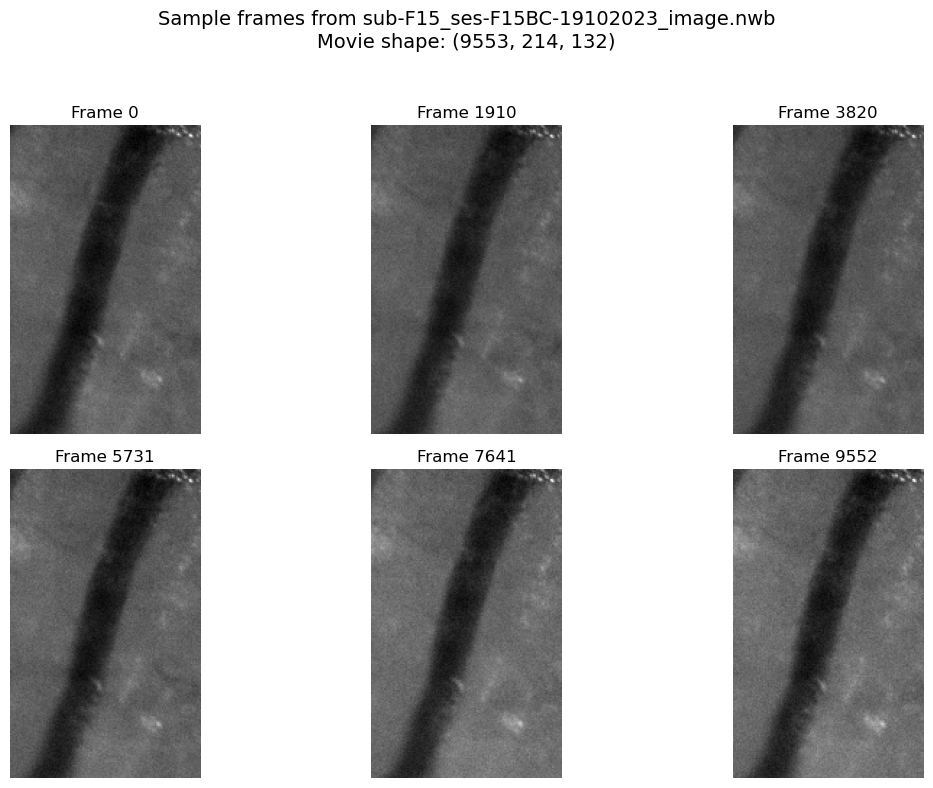

In [5]:
# Extract sample frames evenly spaced throughout the movie
shape = movies.data.shape
example_indices = np.linspace(0, shape[0]-1, 6, dtype=int)

# Load sample frames
frames = []
for idx in example_indices:
    frame = movies.data[idx, :, :]
    frames.append(frame)

# Create visualization
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.imshow(frames[i], cmap='gray')
    ax.set_title(f'Frame {example_indices[i]}')
    ax.axis('off')

plt.suptitle(f'Sample frames from {nwb_path.split("/")[-1]}\nMovie shape: {shape}', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Time Series Analysis: Vessel Intensity Dynamics

We can extract intensity profiles from the vessel region to analyze temporal dynamics that reflect vessel diameter changes and pulsatility.

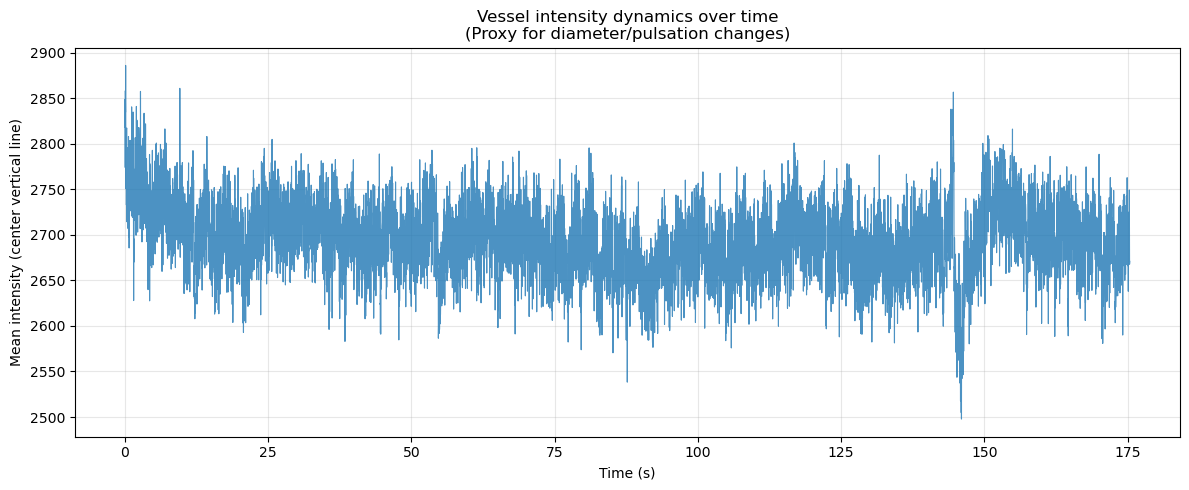

Recording duration: 175.4 seconds
Intensity range: 2498 - 2886


In [6]:
# Extract intensity trace from center column over time
column = shape[2] // 2  # Center column
rows = np.arange(shape[1]//2-3, shape[1]//2+3)  # Small band around center

# Calculate mean intensity across the selected region for each frame
line_trace = []
for frame_idx in range(shape[0]):
    frame = movies.data[frame_idx, :, :]
    profile = frame[rows, column]
    line_trace.append(np.mean(profile))

line_trace = np.array(line_trace)
time = np.arange(shape[0]) / movies.rate  # Convert frames to seconds

# Plot the intensity time series
plt.figure(figsize=(12, 5))
plt.plot(time, line_trace, lw=0.8, alpha=0.8)
plt.xlabel('Time (s)')
plt.ylabel('Mean intensity (center vertical line)')
plt.title('Vessel intensity dynamics over time\n(Proxy for diameter/pulsation changes)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Recording duration: {time[-1]:.1f} seconds")
print(f"Intensity range: {line_trace.min():.0f} - {line_trace.max():.0f}")

## Comparing Data Across Subjects

Let's examine the metadata from the second NWB file to understand subject and experimental differences.

In [7]:
# Load the second NWB file for comparison
nwb_path2 = 'sub-031224-M4/sub-031224-M4_ses-03122024-m4-baseline_image.nwb'
nwbfile2, movies2, asset2 = load_nwb_file('001366', '0.250324.1603', nwb_path2)

# Compare key parameters between the two files
print("Comparison between subjects:")
print("=" * 50)

subjects_data = [
    {
        'file': nwb_path.split('/')[-1],
        'subject_id': nwbfile.subject.subject_id,
        'sex': nwbfile.subject.sex,
        'age': nwbfile.subject.age,
        'institution': nwbfile.institution,
        'frame_rate': movies.rate,
        'num_frames': movies.data.shape[0],
        'frame_shape': movies.data.shape[1:],
        'duration': movies.data.shape[0] / movies.rate
    },
    {
        'file': nwb_path2.split('/')[-1],
        'subject_id': nwbfile2.subject.subject_id,
        'sex': nwbfile2.subject.sex,
        'age': nwbfile2.subject.age,
        'institution': nwbfile2.institution,
        'frame_rate': movies2.rate,
        'num_frames': movies2.data.shape[0],
        'frame_shape': movies2.data.shape[1:],
        'duration': movies2.data.shape[0] / movies2.rate
    }
]

for i, data in enumerate(subjects_data, 1):
    print(f"Subject {i}:")
    print(f"  File: {data['file']}")
    print(f"  Subject ID: {data['subject_id']}")
    print(f"  Sex: {data['sex']}, Age: {data['age']}")
    print(f"  Institution: {data['institution']}")
    print(f"  Frame rate: {data['frame_rate']} Hz")
    print(f"  Frames: {data['num_frames']:,}")
    print(f"  Frame size: {data['frame_shape'][0]}×{data['frame_shape'][1]} pixels")
    print(f"  Duration: {data['duration']:.1f} seconds")
    print()

Comparison between subjects:
Subject 1:
  File: sub-F15_ses-F15BC-19102023_image.nwb
  Subject ID: F15
  Sex: F, Age: P9W/P16W
  Institution: University of Copenhagen
  Frame rate: 54.47 Hz
  Frames: 9,553
  Frame size: 214×132 pixels
  Duration: 175.4 seconds

Subject 2:
  File: sub-031224-M4_ses-03122024-m4-baseline_image.nwb
  Subject ID: 031224_M4
  Sex: M, Age: P2M
  Institution: University of Rochester
  Frame rate: 30.0 Hz
  Frames: 6,000
  Frame size: 512×512 pixels
  Duration: 200.0 seconds



## Code Template for General Use

Here's a reusable template for loading and exploring any NWB file from this Dandiset:

In [8]:
# Template function for exploring NWB files from this Dandiset
def explore_vessel_data(asset_path, dandiset_id='001366', version='0.250324.1603'):
    """
    Template function to load and summarize vessel imaging data from this Dandiset.
    
    Parameters:
    -----------
    asset_path : str
        Path to the NWB file within the Dandiset
    dandiset_id : str
        Dandiset identifier (default: '001366')
    version : str
        Dandiset version (default: '0.250324.1603')
    
    Returns:
    --------
    dict : Summary of metadata and data characteristics
    """
    # Load the NWB file
    nwbfile, movies, asset = load_nwb_file(dandiset_id, version, asset_path)
    
    # Extract metadata
    summary = {
        'session_id': nwbfile.session_id,
        'subject_id': nwbfile.subject.subject_id,
        'species': nwbfile.subject.species,
        'sex': nwbfile.subject.sex,
        'age': nwbfile.subject.age,
        'institution': nwbfile.institution,
        'frame_rate': movies.rate,
        'num_frames': movies.data.shape[0],
        'frame_shape': movies.data.shape[1:],
        'duration_seconds': movies.data.shape[0] / movies.rate,
        'data_type': str(movies.data.dtype)
    }
    
    return summary, nwbfile, movies

# Example usage
summary, _, _ = explore_vessel_data('sub-F15/sub-F15_ses-F15BC-19102023_image.nwb')
print("File summary:")
for key, value in summary.items():
    print(f"  {key}: {value}")

File summary:
  session_id: F15BC-19102023
  subject_id: F15
  species: Mus musculus
  sex: F
  age: P9W/P16W
  institution: University of Copenhagen
  frame_rate: 54.47
  num_frames: 9553
  frame_shape: (214, 132)
  duration_seconds: 175.38094363870022
  data_type: uint16


## Potential Analysis Applications

This Dandiset enables various vessel analysis approaches:

**1. Vessel Diameter Quantification**
- Line-profile fitting and edge detection
- Radon transform methods
- Full width at half maximum (FWHM) analysis

**2. Pulsatility Analysis**
- Frequency domain analysis of diameter traces
- Pulse amplitude and shape characterization
- Correlation with physiological rhythms

**3. Method Comparison**
- Benchmark different vessel segmentation algorithms
- Evaluate sensitivity to noise and contrast variations
- Cross-validate results across subjects and conditions

The consistent NWB structure and comprehensive metadata support reproducible analysis workflows and method development for vessel imaging studies.